<a href="https://colab.research.google.com/github/juanlu29/juanlu29/blob/contaminacionMadrid/preprocesadoDatosContaminacionMadrid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Visualizacion de datos de contaminacion de Madrid. Hasta ahora dispongo de 

## Plaza del Cármen, NO2
## Casa de campo, NO2, O3
## Plaza elíptica, Fernández Ladreda,  NO2

Cuatro datasets

El formato es diario partiendo del día 1-1-2010 y las unidades micro g/m^3

In [1]:
import pandas as pd
from google.colab import drive
import numpy as np
drive.mount('/content/drive/')

# librerias usadas
import altair as alt
from vega_datasets import data
import matplotlib.pyplot as plt
from scipy.fft import fft
import matplotlib.pyplot as plt
import sys
import random


# Exploramos los directorios de drive. Cambiamos directorio a donde estan los datos
%cd /content/drive/My\ Drive/datosContaminacionMadrid

# Lo pasamos a dataframes
est56NO2_df = pd.read_csv('Est56FL_CodPar08NO2_valuesonly.txt', header=0)
est24NO2_df = pd.read_csv('Est24CC_CodPar08NO2_valuesonly.txt', header=0)
est03NO2_df = pd.read_csv('Est03PlC_CodPar08NO2_valuesonly.txt', header=0)
est03O3_df  = pd.read_csv('Est03PlC_CodPar14O3_valuesonly.txt', header=0)




Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/datosContaminacionMadrid


Visualizacion interactiva de datos

In [2]:



alt.Chart(est56NO2_df.reset_index()).mark_point().encode(
    x='index',
    y='x',
).interactive()



alt.Chart(...)

In [3]:
alt.Chart(est03O3_df.reset_index()).mark_line().encode(
    x='index',
    y='x',
).interactive()

alt.Chart(...)

In [4]:
alt.Chart(est03NO2_df.reset_index()).mark_line().encode(
    x='index',
    y='x',
).interactive()

alt.Chart(...)

3834


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: RuntimeWarning: divide by zero encountered in log10


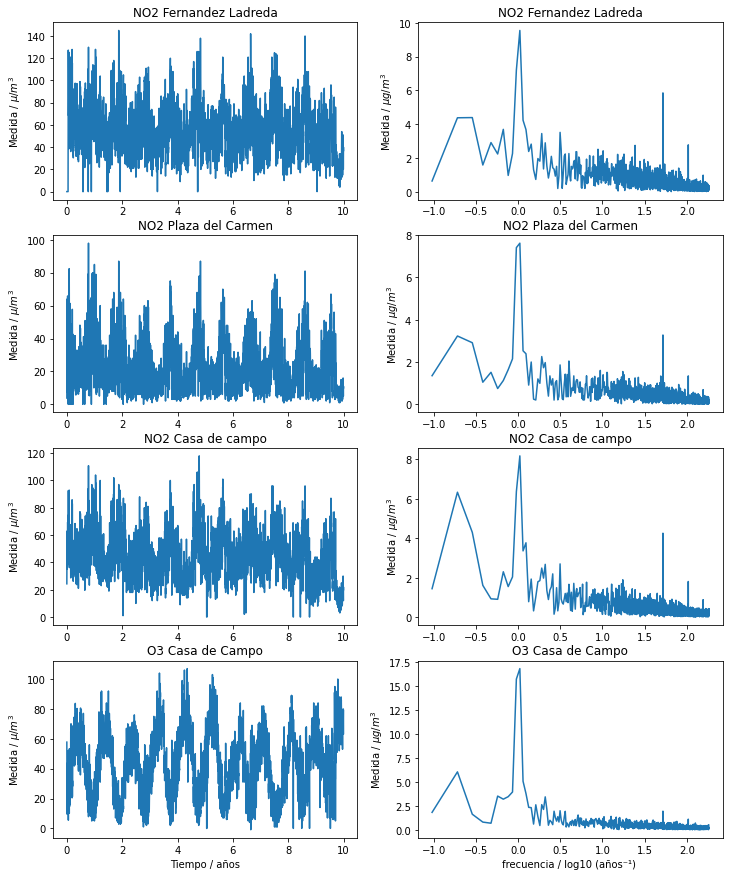

In [3]:
def frecuenciasInternas(datos,dx):
  '''
  Dada una serie de datos devuelve el espectro de frecuencias que lo compone y el dominio espectral correspondiente
  dx la unidad minima en la que el dominio esta particionado
  '''
  datosf = fft(datos)


  x = np.linspace(0.0, len(datos)*dx, len(datos))
  xf = np.linspace(0.0, (2*np.pi)/(len(datos)*dx), len(datos)//2)

  s_datosf_sq = np.real((2./len(datos))*np.sqrt(np.multiply(datosf,np.conj(datosf)))[0:len(datos)//2])

  return s_datosf_sq, xf



grid_plots_datos, [(axg1,axg5),(axg2,axg6),(axg3,axg7),(axg4,axg8)] = plt.subplots(4,2,figsize=(12,15))
est56NO2_np = est56NO2_df.to_numpy()
est24NO2_np = est24NO2_df.to_numpy()
est03NO2_np = est03NO2_df.to_numpy()
est03O3_np = est03O3_df.to_numpy()
x = np.linspace(0,10,len(est03O3_np))
print(len(est03O3_np))

axg1.plot(x,est56NO2_np)
axg1.set_title("NO2 Fernandez Ladreda")
axg1.set_ylabel("Medida / $\mu / m^{3}$")
axg2.plot(x,est24NO2_np)
axg2.set_title("NO2 Plaza del Carmen")
axg2.set_ylabel("Medida / $\mu / m^{3}$")
axg3.plot(x,est03NO2_np)
axg3.set_title("NO2 Casa de campo")
axg3.set_ylabel("Medida / $\mu / m^{3}$")
axg4.plot(x,est03O3_np)
axg4.set_title("O3 Casa de Campo")
axg4.set_xlabel("Tiempo / años")
axg4.set_ylabel("Medida / $\mu / m^{3}$")

# Frecuencias
frecuencias56, xf56 = frecuenciasInternas(est56NO2_np[:,0],1.)
frecuencias24, xf24 = frecuenciasInternas(est24NO2_np[:,0],1.)
frecuencias03NO2, xf03NO2= frecuenciasInternas(est03NO2_np[:,0],1.)
frecuencias03O3, xf03O3 = frecuenciasInternas(est03O3_np[:,0],1.)

#periodos56 = np.arange(len(frecuencias56))*((2*np.pi)/(len(est56NO2_np)*(1./365)))
periodos56 = np.linspace(0,365./2.,len(frecuencias56))

periodos24 = np.linspace(0,365./2.,len(frecuencias56))

periodos03NO2 = np.linspace(0,365./2.,len(frecuencias56))

periodos03O3 = np.linspace(0,365./2.,len(frecuencias56))

axg5.plot(np.log10(periodos56),frecuencias56)
axg5.set_title("NO2 Fernandez Ladreda")
axg5.set_ylabel("Medida / $\mu g/ m^{3}$")
axg6.plot(np.log10(periodos24),frecuencias24)
axg6.set_title("NO2 Plaza del Carmen")
axg6.set_ylabel("Medida / $\mu g/ m^{3}$")
axg7.plot(np.log10(periodos03NO2),frecuencias03NO2)
axg7.set_title("NO2 Casa de campo")
axg7.set_ylabel("Medida / $\mu g/ m^{3}$")
axg8.plot(np.log10(periodos03O3),frecuencias03O3)
axg8.set_title("O3 Casa de Campo")
axg8.set_xlabel("frecuencia / log10 (años⁻¹) ")
axg8.set_ylabel("Medida / $\mu g/ m^{3}$")

grid_plots_datos.show()

#print( "Frecuencia promedio de la señal :",   np.sum(   np.multiply(   periodos , frecuencias/np.sum(frecuencias)    )    )    )
#frecuenciaMaxima = np.where(frecuencias == np.amax(frecuencias)) # Operador & para evaular elemento a elemento entre arrays
#print("frecuencia maxima :",frecuencias[frecuenciaMaxima])
#print( "Frecuencia máxima de la señal :", periodos[frecuenciaMaxima])

## Calculo de correlaciones en los datos.

In [10]:



class correlaciones_promedio:
  '''
  Las instancias de esta clase interpretan una serie temporal 1D en una sucesion de realizaciones de procesos estocásticos de 
  longitud o duracion inferior a la serie temporal, aceptando la implicacióón de que al dividir la serie temporal los procesos
  resultantes están ausentes de correlacion.
  '''

  def __init__(self,n,p,serie):
    self.Serie = serie # Array numpy con la serie temporal 1dimensional
    self.N = n # Numero de medidas totales de la serie temporal
    self.P = p # Numero de medidas que debe contener cada subconjunto de la serie dada a particionar para obtener correlaciones
    self.Np = self.N // self.P # # Numero de particiones a realizar posibles
    if self.Np < 10:
      raise NameError("Son menos de 10 realizaciones para promediar")
  
    #self.normalizacionDatos()
    #self.particionar()
    self.particionar2()
    self.mediaCovCompt()
    self.corrEstPromCompt()

  def normalizacionDatos(self):
    '''
    Queremos comparar correlaciones con posibles kernels a los que asociar los datos
    Estos kernels son asociados como distribucióón a priori y yo siempre trabajo con sklearn
    con la opción de normalización. Por ello ahora vamos a normalizar nuestra serie para que
    tenga media cero y desviacióón estándar unidad.
    '''

    # Calculo del promedio de los procesos resultantes del particionado
    self.Media = (1./float(self.N))*np.sum(self.Serie)
    self.Serie = self.Serie - self.Media
    self.Media = np.zeros(self.P)

    # Seguidamente, reescalado para desviación estándar de unidad. 
    sig_sq = np.sum(np.power(self.Serie,2))*(1./float(self.N))
    sig = np.sqrt(sig_sq)
    self.Serie = self.Serie/sig

  def particionar2(self):
    '''
    Aquí particionamos simplemente desplazando nuestra ventana temporal 1 dia cada vez y tomando eso como "vector de variables aleatoria".
    '''
    self.Series = []
    dias = 0
    while dias<(self.N-self.P):
      self.Series.append(self.Serie[dias:dias+self.P])
      dias += 1
    
    self.Np = dias
    self.Series = np.asarray(self.Series)


    self.Media = (1./float(self.P))*np.sum((1./float(self.Np))*np.sum(self.Series))

    self.Serie = self.Serie - self.Media

  def particionar(self):
    '''
    Particiona la serie temporal de acuedo al numero de particiones P calculado
    '''
    serie_p = self.Serie[0:self.P*self.Np]
    self.Series = np.asarray(np.split(serie_p,self.Np))

  def mediaCovCompt(self):
    '''
    Interpreta la serie temporal como un proceso estocástico estacionario en el cual podemos samplear muestras que 
    poseen las mismas propiedades estacionarias y asi analizar la correlacion de su ruido
    '''
    
    # Promediado
    # Corr(x,x') = < (x - x_media)*(x'-x_media) >
    # Para crear los arrays x - x_media, dado el vector media y el array x con tamaño realizaciones*dominio, 
    # hago uso de la funcion np.full() que generar un array de dimension deseada rellenando de manera repetitiva con un subarray. 
    # En este caso la medida se generaliza a todas las filas de una matriz para que la operacion x-x_media tenga sentido
    # Luego el productor matricial, si solo fuera fila traspuesta por fila misma, genera una matriz de productos punto a punto que constituyen una realizacion de la correlacion a medir
    # Si luego lo hacemos matricialmente, con las matrices incluyendo todas las realizaciones, el producto matricial es equivalente a hacer lo anterior y sumar. Es decir promediamos
    # Finalmente factor de normalizacion esta incluido
    medida_diff_media = (self.Series-np.full(np.shape(self.Series),self.Media))*np.sqrt(1./float(self.Np))
    self.Correlacion = np.matmul(medida_diff_media.T,medida_diff_media)

  def corrEstPromCompt(self):
    '''
    Aproximación de que las correlaciones dependen exclusivamente de la distancia punto a punto
    Con los datos de correlacion disponibles, promedia sobre todas las combinaciones de distancia posibles punto a punto
    '''

    # Primero Consideramos la matriz formada por las correlaciones punto a punto por encima (U) y por debajo (D) de la diagonal y 
    # Vamos promediando donde haya puntos disponibles y en caso contrario añadimos ceros. La idea es con la información que tenemos 
    # promediar para obtener C(x,x') - C(|x-x'|).         
    corr_U = np.asarray([np.concatenate((self.Correlacion[i,i:self.P],np.zeros(i)) ) for i in range(self.P)])
    corr_D = np.asarray([np.flip(np.concatenate((np.zeros(self.P-i-1),self.Correlacion[i,0:i+1]))) for i in range(self.P)])

    # Seguidamente, estas dos matrices son equivalentes en la aproximacion y se suman para obtener el promedio con la cantidad de puntos
    # que se han sumado. Estos puntos para promediar van desde 2*self.P a 2, porque es un promediado sobre dimensiones de la matriz de correlacion
    corrEst = np.sum(corr_U + corr_D,axis=0)
    self.CorrEstProm =  np.asarray([corrEst[i]/(2*self.P-i*2) for i in range(self.P)])


################


est56NO2_np = est56NO2_df.to_numpy()
est24NO2_np = est24NO2_df.to_numpy()
est03NO2_np = est03NO2_df.to_numpy()
est03O3_np = est03O3_df.to_numpy()


longitudDatos = len(est56NO2_np)

dx = (1./7) # Vamos a presentar en semanas la correlacion

r10 = np.linspace(0,longitudDatos//10*dx,longitudDatos//10)
p28 = 365
r28 = np.arange(p28) 
r190 = np.linspace(0,longitudDatos//190*dx,longitudDatos//190)

####


#correlaciones_56NO2_r190 = correlaciones_promedio(r190,len(est56NO2_np),190,est56NO2_np[:,0])
#correlaciones_24NO2_r190 = correlaciones_promedio(r190,len(est24NO2_np),190,est24NO2_np[:,0])
#correlaciones_03NO2_r190 = correlaciones_promedio(r190,len(est03NO2_np),190,est03NO2_np[:,0])
#correlaciones_03O3_r190 = correlaciones_promedio(r190,len(est03NO2_np),190,est03O3_np[:,0])

correlaciones_56NO2_r28 = correlaciones_promedio(len(est56NO2_np),p28,est56NO2_np[:,0])
correlaciones_24NO2_r28 = correlaciones_promedio(len(est24NO2_np),p28,est24NO2_np[:,0])
correlaciones_03NO2_r28 = correlaciones_promedio(len(est03NO2_np),p28,est03NO2_np[:,0])
correlaciones_03O3_r28 = correlaciones_promedio(len(est03O3_np),p28,est03O3_np[:,0])

#correlaciones_56NO2_r10 = correlaciones_promedio(r10,len(est56NO2_np),10,est56NO2_np[:,0])
#correlaciones_24NO2_r10 = correlaciones_promedio(r10,len(est24NO2_np),10,est24NO2_np[:,0])
#correlaciones_03NO2_r10 = correlaciones_promedio(r10,len(est03NO2_np),10,est03NO2_np[:,0])
#correlaciones_03O3_r10 = correlaciones_promedio(r10,len(est03O3_np),10,est03O3_np[:,0])







parametros encontrados : [ 4.11422560e+02  6.00370143e+00  6.49550164e+02 -5.52476700e+02
  4.81040180e-01  3.83746435e-01  1.55398539e-01  1.41884543e-01
  8.57843862e-03]


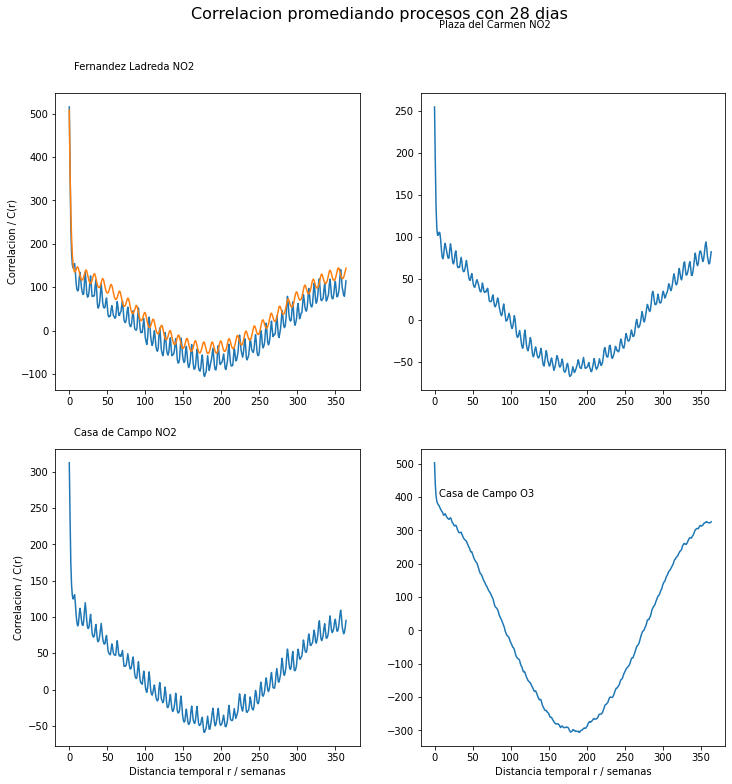

In [55]:
from scipy.optimize import curve_fit

# define the true objective function
def objective(x, a, b, c, d, l1, l2, l3, omega1, omega2):
	return a * np.exp(-l1*x) + b*np.exp(-2*l2*np.power(np.sin(omega1*x),2)) + c*np.exp(-2*l3*np.power(np.sin(omega2*x),2)) + d

# Figuras de las estaciones anteriores

#grid_plots_datos_10, [(ax11a,ax12a),(ax21a,ax22a)] = plt.subplots(2,2,figsize=(12,12))
grid_plots_datos_28, [(ax11b,ax12b),(ax21b,ax22b)] = plt.subplots(2,2,figsize=(12,12))
#grid_plots_datos_190, [(ax11c,ax12c),(ax21c,ax22c)] = plt.subplots(2,2,figsize=(12,12))

# Particionado en 10 subprocesos estocásticos

#ax11a.plot(r10,correlaciones_56NO2_r10.CorrEstProm)
 
#ax12a.plot(r10,correlaciones_24NO2_r10.CorrEstProm)
 
#ax21a.plot(r10,correlaciones_03NO2_r10.CorrEstProm)
    
#ax22a.plot(r10,correlaciones_03O3_r10.CorrEstProm)

#grid_plots_datos_10.suptitle('Correlacion promediando 10 veces',fontsize=16)
#ax11a.set_ylabel("Correlacion / C(r)")
#ax21a.set_ylabel("Correlacion / C(r)")
##ax21a.set_xlabel("Distancia temporal r / semanas")
#ax22a.set_xlabel("Distancia temporal r / semanas")

##ax11a.text(20,600,"Fernandez Ladreda NO2")
#ax12a.text(20,250,"Plaza del Carmen NO2")
#ax21a.text(20,300,"Casa de Campo NO2")
#ax22a.text(20,300,"Casa de Campo O3")

#grid_plots_datos_10.show()

# Particionado en procesos de 28 días

aproximacion1_x = np.arange(p28)
aproximacion1_y = 250*np.exp(-(1./3.3)*aproximacion1_x)
aproximacion2_y = 100.*np.exp(-2*(0.3)*np.power(np.sin(np.pi*aproximacion1_x*(1./7.)),2))
aproximacion3_y = 250*np.power(np.exp(-2*(1.)*np.power(np.sin(np.pi*aproximacion1_x*(1./365.)),2)),1.005) - 100.

# curve fit
popt, _ = curve_fit(objective, np.arange(p28), correlaciones_56NO2_r28.CorrEstProm, p0=[250,100,250,-100,1./3.3,0.3,1.,1./7.,1./365.] )
# summarize the parameter values
a, b, c, d, l1, l2, l3, omega1, omega2 = popt
print("parametros encontrados :",popt)

ajuste =  objective(aproximacion1_x, a-50., 50., c, d, l1, l2, l3, 0.284, omega2)

ax11b.plot(r28,correlaciones_56NO2_r28.CorrEstProm)
ax11b.plot(aproximacion1_x,ajuste)

ax12b.plot(r28,correlaciones_24NO2_r28.CorrEstProm)
 
ax21b.plot(r28,correlaciones_03NO2_r28.CorrEstProm)
    
ax22b.plot(r28,correlaciones_03O3_r28.CorrEstProm)
#ax22b.plot(r28,correlaciones_56NO2_r28.Media)

grid_plots_datos_28.suptitle('Correlacion promediando procesos con 28 dias',fontsize=16)
ax11b.set_ylabel("Correlacion / C(r)")
ax21b.set_ylabel("Correlacion / C(r)")
ax21b.set_xlabel("Distancia temporal r / semanas")
ax22b.set_xlabel("Distancia temporal r / semanas")

ax11b.text(6,600,"Fernandez Ladreda NO2")
ax12b.text(6,350,"Plaza del Carmen NO2")
ax21b.text(6,350,"Casa de Campo NO2")
ax22b.text(6,400,"Casa de Campo O3")




grid_plots_datos_28.show()



# Particionado en 190 subprocesos estocásticos


#ax11c.plot(r190,correlaciones_56NO2_r190.CorrEstProm)
 
#ax12c.plot(r190,correlaciones_24NO2_r190.CorrEstProm)
 
#ax21c.plot(r190,correlaciones_03NO2_r190.CorrEstProm)
    
#ax22c.plot(r190,correlaciones_03O3_r190.CorrEstProm)

#grid_plots_datos_190.suptitle('Correlacion promediando 190 veces',fontsize=16)
#ax11c.set_ylabel("Correlacion / C(r)")
#ax21c.set_ylabel("Correlacion / C(r)")
#ax21c.set_xlabel("Distancia temporal r / semanas")
#ax22c.set_xlabel("Distancia temporal r / semanas")


#ax11c.text(1.5,600,"Fernandez Ladreda NO2")
#ax12c.text(1.5,280,"Plaza del Carmen NO2")
#ax21c.text(1.5,350,"Casa de Campo NO2")
#ax22c.text(1.5,500,"Casa de Campo O3")


#grid_plots_datos_190.show()


In [ ]:
# Comparacion de matriz de correlacion respecto correlacion estacionaria promedio obtenida de todo el conjunto de datos
# Particiones de 190 datos

fig_comparacion_matriz_estacionaria_exp, (ax_exp,ax_est,ax_diff) = plt.subplots(1,3,figsize=(15,6))

P = correlaciones_56NO2_r190.P
m_Cor = correlaciones_56NO2_r190.Correlacion
cor_Prom = correlaciones_56NO2_r190.CorrEstProm
m_Cor_Prom = np.asarray([ np.concatenate( ( np.flip(cor_Prom[0:i+1]), cor_Prom[1:P-i]  ) )  for i in range(P)])
m_diff = np.abs(m_Cor-m_Cor_Prom)/m_Cor

im1 = ax_exp.imshow(m_Cor,vmin=np.amin(m_Cor),vmax=np.amax(m_Cor),cmap='jet', aspect = 'auto')
im2 = ax_est.imshow(m_Cor_Prom,vmin=np.amin(m_Cor_Prom),vmax=np.amax(m_Cor_Prom),cmap='jet', aspect = 'auto')
im3 = ax_diff.imshow(m_diff,vmin=np.amin(m_diff), vmax=np.amax(m_diff), cmap='jet', aspect='auto')


fig_comparacion_matriz_estacionaria_exp.colorbar(im1, ax=ax_exp)
fig_comparacion_matriz_estacionaria_exp.colorbar(im2, ax=ax_est)
fig_comparacion_matriz_estacionaria_exp.colorbar(im3, ax=ax_diff)

fig_comparacion_matriz_estacionaria_exp.show()

# Comparacion de matriz de correlacion respecto correlacion estacionaria promedio obtenida de todo el conjunto de datos
# Particiones de 10 datos

fig_comparacion_matriz_estacionaria_exp, (ax_est,ax_exp,ax_diff) = plt.subplots(1,3,figsize=(15,6))

P = correlaciones_56NO2_r10.P
m_Cor = correlaciones_56NO2_r10.Correlacion
cor_Prom = correlaciones_56NO2_r10.CorrEstProm
m_Cor_Prom = np.asarray([ np.concatenate( ( np.flip(cor_Prom[0:i+1]), cor_Prom[1:P-i]  ) )  for i in range(P)])
m_diff = np.abs(m_Cor-m_Cor_Prom)/np.abs(m_Cor)

im1 = ax_exp.imshow(m_Cor_Prom,vmin=np.amin(m_Cor_Prom),vmax=np.amax(m_Cor_Prom),cmap='jet', aspect = 'auto')
im2 = ax_est.imshow(m_Cor,vmin=np.amin(m_Cor),vmax=np.amax(m_Cor),cmap='jet', aspect = 'auto')
im3 = ax_diff.imshow(m_diff,vmin=np.amin(0), vmax=np.amax(2), cmap='jet', aspect='auto')


fig_comparacion_matriz_estacionaria_exp.colorbar(im1, ax=ax_exp)
fig_comparacion_matriz_estacionaria_exp.colorbar(im2, ax=ax_est)
fig_comparacion_matriz_estacionaria_exp.colorbar(im3, ax=ax_diff)

fig_comparacion_matriz_estacionaria_exp.show()




fig_medio, ax_medio = plt.subplots(1,1)
ax_medio.plot(r190,correlaciones_56NO2_r190.CorrEstProm,'o',label='Promedio aproximacion correlacion estacionaria')
ax_medio.plot(r190,correlaciones_56NO2_r190.Correlacion[0,:],'p',label='Correlacion entre t=0 y t =3 semanas')
ax_medio.legend()
ax_medio.set_ylabel('Correlación / C(r)')
ax_medio.set_xlabel('Distancia temporal / r (semanas)')
fig_medio.show()

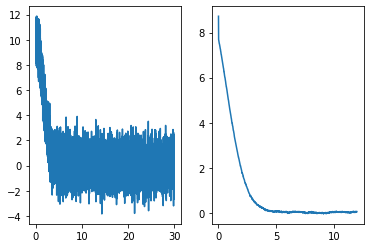

In [ ]:

# Un ejemplo de juguete para ver si tiene sentido lo que estoy pensando
x = np.linspace(0,30,10000)
Sruido = 1.
ruido = Sruido*np.fromiter([random.gauss(0.0, 1.0) for i in range(10000)],float)
l = 5.
A = 10.
datos = A*np.exp(-np.power(x,2)/l) + ruido

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(x,datos)

correlacion = np.zeros(1000)
x_corr = np.zeros(1000)
f = 4
inc = 0
for j in range(1000):
  x_corr[j] = x[inc]
  for i in range(10000-4000):
    correlacion[j] += datos[i]*datos[i+inc]
  correlacion[j] = correlacion[j]/(10000-4000)
  inc = inc + f

ax2.plot(x_corr,correlacion)

fig.show()


He probado a partir de la premisa que los datos corresponden a un proceso estocástico estacionario sobre el que calcular correlaciones para estimar cuantos puntos son suficientes para ser incorporados al entrenamiento de un proceso gaussiano. 

La realidad es que la correlacion nunca tiende estacionariamente a cero con los datos proporcionados (intentando que promediemos siempre sobre 20 realizaciones como minimo del proceso estocastico que conforma la serie temporal). He asumido que partiendo la serie temporal en trozos independientes estamos "sampleando" el proceso estocastico sobre el que obtenemos estas correlaciones.

Pues las correlaciones nunca tienden a cero, bien se hacen negativas y no somos capaces de calcular correlaciones a tiempos mas largos. El promedio del proceso estocastico es posible de computar pero son muy fluctuantes.

En el mejor de los casos me faltan datos para extraer la informacion que deseo de los datos y el hecho de que el proceso no tiende a una media constante pues implica que no es estacionario y no podemos hacer esta aproximación.

Creo que he confundido ciertos conceptos pero para esta serie temporal que modula no podemos presuponer un "conjunto de datos sobre que la memoria del proceso es cero si realizamos mas alla".

Proceso de Ornstein–Uhlenbeck

Voy a generar un proceso de esta naturaleza resolviendo la ec. diferencial estocástica pertinente y vamos a calcular su matriz de covarianza y vamos
a compararlo con la proveniente del kernel que hace que un proceso gausiano genere este tipo de trayectorias

Calculamos muestra
Calculamos correlaciones


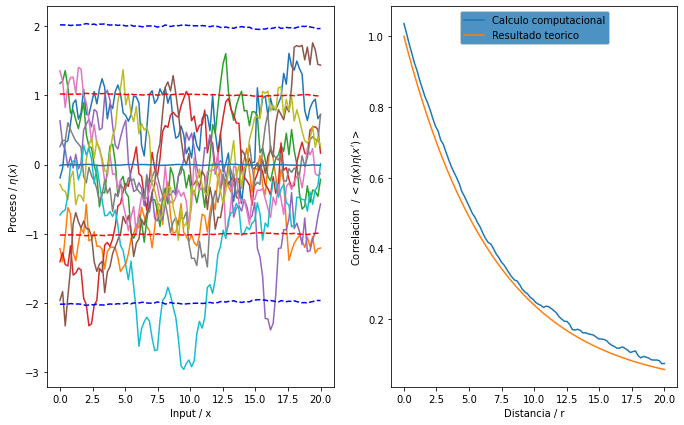

In [ ]:



def procesoOU(n,dt,tau):
  '''
  Genera un proceso OU
  n es la longitud del proceso estocástico
  dt es el paso temporal
  tau es la escala caracteríística de tiempos del proceso
  '''

  def relacionRecursiva(i,dt,tau,xiou):
    '''
    Esta funcion es para calcular de forma recursiva los diferentes terminos del proceso OU en el que la amplitud de la covarianza es la unidad 
    independientemente de la escala temporal
    '''
    if i == 0:
      xiou[0] = random.gauss(0,1) 
    else:
      xiou[i] = xiou[i-1]*np.exp(-dt/tau)+np.sqrt(1-np.exp(-(2*dt)/tau))*random.gauss(0,1)

    return xiou[i]

  xiou = np.zeros(n)

  realizacionOU = np.asarray([ relacionRecursiva(i,dt,tau,xiou) for i in range(n)])

  return realizacionOU

def matrizCov(muestra,longitudProceso,realizaciones):
  '''
  La muestra es un iterable o lista con un numero determinado de muestras del proceso sobre el que calcular correlaciones
  '''

  # Es una matriz
  correlacion = np.zeros([longitudProceso,longitudProceso])

  # Necesitamos derivar la media previamente
  media = np.zeros(longitudProceso)
  media = (1./float(realizaciones))*np.sum(muestra, axis=0)

  # Promediando
  for k in range(realizaciones):
    vectorfila = np.array([muestra[k]-media])
    productosCovariantes = np.matmul(vectorfila.T,vectorfila)
    correlacion += productosCovariantes # Es una suma de matrices

  # Normalizado de la matriz
  correlacion = correlacion*(1./float(realizaciones))
  return np.asarray(correlacion), np.asarray(media)




n = 4000 # realizacones
m = 100 # longitud Proceso
dt = 0.2 # paso temporal
tau = 7. # Escala temporal del proceso


x = np.linspace(0,m*dt,m) # dominio del proceso

print("Calculamos muestra")
muestra = [procesoOU(m,dt,tau) for i in range(n)]

print("Calculamos correlaciones")
corr, media = matrizCov(muestra,m,n)

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(11.3,7))

ax2.plot(x,corr[0,:], label='Calculo computacional')
#ax2.plot(x,media)
#ax2.plot(x,(1./(2*tau))*np.exp(-x/tau), label='Resultado teorico')
ax2.plot(x,np.exp(-x/tau), label='Resultado teorico')

[ax1.plot(x,muestra[i][:]) for i in range(10)]

sigma = np.asarray([np.sqrt(corr[i,i]) for i in range(m)])


data_set = {}
index = []
for i  in range(m):
  data_set['x'+str(i)] = corr[i,:]

for j in range(m):
  index.append("x"+str(j))

corr_csv = pd.DataFrame(data_set,index)
corr_csv.to_csv('K_OU_experimental.csv')



ax1.plot(x,media)
ax1.plot(x,sigma,'r--')
ax1.plot(x,1.98*sigma,'b--')
ax1.plot(x,-sigma,'r--')
ax1.plot(x,-1.98*sigma,'b--')
ax1.set_xlabel('Input / x')
ax2.set_xlabel('Distancia / r')
ax1.set_ylabel('Proceso / $\eta ( x ) $')
ax2.set_ylabel('Correlacion  / $ < \eta  ( x ) \eta ( x \' )> $')
ax2.legend(loc='upper center').get_frame().set_facecolor('C0')



fig.show()